Manufactured Solution experiment based on SAND2000 - 1444

Test based on [CHiMaD Phase Field Benchmark Problem 7](https://pages.nist.gov/pfhub/benchmarks/benchmark7.ipynb)

## Import Python modules

In [1]:
import argparse
import json
import os
import re
import sys
import time
import json
import fipy as fp
try:
    import pathlib
except ImportError:
    import pathlib2 as pathlib

In [21]:
from sympy import Symbol, symbols, simplify, init_printing, Rational
from sympy import Eq, sin, cos, tanh, sqrt, pi
from sympy.printing import pprint
from sympy.abc import kappa, S, t, x, xi, y, alpha

from sympy.physics.vector import ReferenceFrame, dynamicsymbols, time_derivative, divergence, gradient

## Initialize
### Load parameters

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--solver", help="solver class to use", default="pcg")
parser.add_argument("--preconditioner", help="preconditioner class to use", default="none")
parser.add_argument("--sweeps", help="number of nonlinear sweeps to take",
                    type=int, default=5)

parser.add_argument("--kappa", help="gradient energy coefficient",
                    type=float, default=0.0004)
parser.add_argument("--A1", help="A1 parameter",
                    type=float, default=0.0075)
parser.add_argument("--B1", help="B1 parameter",
                    type=float, default=8 * pi)
parser.add_argument("--A2", help="A2 parameter",
                    type=float, default=0.03)
parser.add_argument("--B2", help="B2 parameter",
                    type=float, default=22 * pi)
parser.add_argument("--C2", help="C2 parameter",
                    type=float, default=0.0625 * pi)

parser.add_argument("--totaltime", help="duration of full simulation",
                    type=float, default=8.)
parser.add_argument("--dt", help="simulation time step",
                    type=float, default=0.1)
parser.add_argument("--Lx", help="simulation size in x dimension",
                    type=float, default=1.0)
parser.add_argument("--Ly", help="simulation size in y dimension",
                    type=float, default=0.5)
parser.add_argument("--nx", help="number of grid cells in x dimension",
                    type=float, default=1024)

parser.add_argument("--iterations", help="maximum number of linear iterations to take for each sweep",
                    type=int, default=1000)
parser.add_argument("--tolerance", help="linear solver tolerance",
                    default=1e-10)
parser.add_argument("--profile",
                    help="store profiling statistics along with other output",
                    action='store_true')
parser.add_argument("--view",
                    help="whether to view the results",
                    action='store_true')

_StoreTrueAction(option_strings=['--view'], dest='view', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='whether to view the results', metavar=None)

In [4]:
args, unknowns = parser.parse_known_args(args=None)

## symbolic form

In [22]:
N = ReferenceFrame('N')
t = symbols('t')

init_printing(use_unicode=True)

# alpha = symbols('a')
A1, A2 = symbols('A1 A2')
B1, B2 = symbols('B1 B2')
C2 = symbols('C2')

# Define interface offset (alpha)
alpha = Rational(1, 4) + A1 * t * sin(B1 * N[0]) + A2 * sin(B2 * N[0] + C2 * t)

# Define the solution equation (eta)
xi = (N[1] - alpha) / sqrt(2*kappa)
eta_sol = (1 - tanh(xi)) / 2

In [24]:
eq_sym = (time_derivative(eta_sol, N)
                  + 4 * eta_sol * (eta_sol - 1) * (eta_sol - Rational(1, 2)) 
                  - divergence(kappa * gradient(eta_sol, N), N))

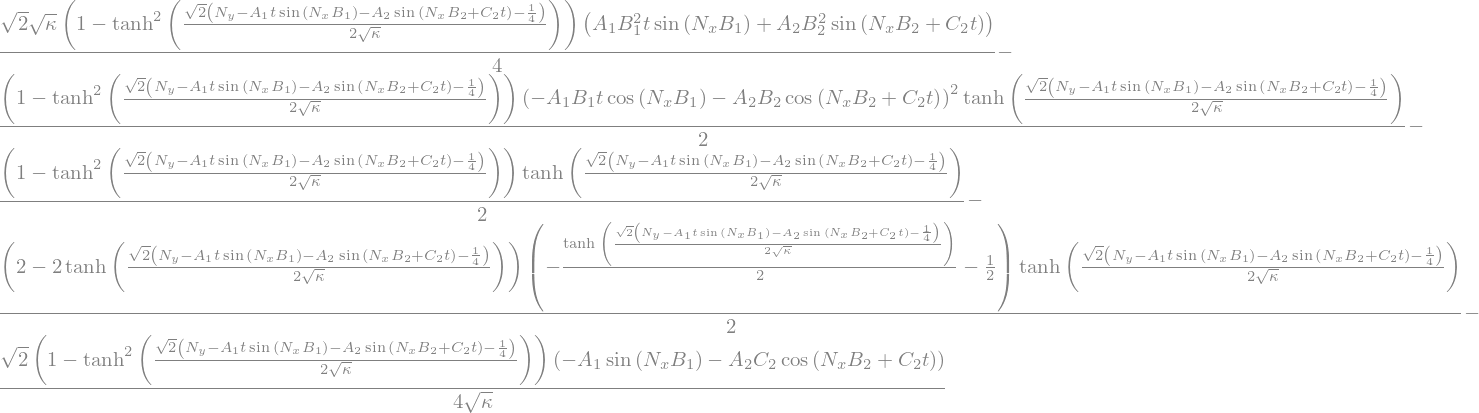

In [25]:
eq_sym

### substitute coefficient values

In [26]:
parameters = ((kappa, args.kappa), 
              (A1, args.A1), (B1, args.B1), 
              (A2, args.A2), (B2, args.B2), 
              (C2, args.C2))

In [27]:
subs = [sub.subs(parameters) for sub in (eq_sym, eta_sol)]

### generate FiPy lambda functions

In [28]:
from sympy.utilities.lambdify import lambdify, lambdastr

In [29]:
(eq_fp, eta_fp) = [lambdify((N[0], N[1], t), sub, modules=fp.numerix) for sub in subs]

In [30]:
kappa_fp = float(kappa.subs(parameters))

## setup FiPy simulation

In [31]:
nx = args.nx
ny = int(nx * args.Ly / args.Lx)
dx = args.Lx / nx
dy = args.Ly / ny
dt = args.dt

mesh = fp.PeriodicGrid2DLeftRight(nx=nx, dx=dx, ny=ny, dy=dy)
xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

elapsed = fp.Variable(name="$t$", value=0.)

eta = fp.CellVariable(mesh=mesh, name=r"$\eta$", hasOld=True)
eta.constrain(1., where=YY==0.)
eta.constrain(0., where=YY==0.5)

eta.value = eta_fp(xx, yy, 0.)

deta = eta - eta_fp(xx, yy, elapsed)
deta.name = r"$\Delta\eta$"

# viewer = fp.Matplotlib2DViewer(vars=deta)

eq = (fp.TransientTerm() == 
      - 4 * eta * (eta - 1) * (eta - 0.5) 
      + fp.DiffusionTerm(coeff=kappa_fp) + eq_fp(xx, yy, elapsed))

### time simulation

In [ ]:
start = time.time()

while elapsed.value <= args.totaltime:
    eta.updateOld()
    eq.solve(var=eta, dt=dt)
    elapsed.value = elapsed() + dt
    # viewer.plot()

end = time.time()

In [ ]:
deta = eta - eta_fp(xx, yy, elapsed - dt)

etaerror2 = (fp.numerix.L2norm(deta * mesh.cellVolumes)
             / fp.numerix.L2norm(mesh.cellVolumes))
etaerrorINF = fp.numerix.LINFnorm(deta)

results = {
    "elapsed / s": end - start,
    "etaerror2": etaerror2,
    "etaerrorINF": etaerrorINF
}

if fp.parallel.procID == 0:
    print(json.dumps(results))